# Assignment 1 - LeNet
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*



In this assignment, I will attempt to recreate the LeNet CNN architecture, similar to what Yann LeCun introduced in 1998, to classify numbers found in the MNIST dataset.

The original LeNet (LeNet-5) architecture consists of two parts: 
1. a convolutional encoder consisting of two convolutional layers (which uses a 5x5 kernel and the scaled hyperbolic tangent activation function) and two average pooling layers,
2. a dense block consisting of three fully-connected layers with the scaled tanh activation function applied to its first and second layers layers, and the euclidiean radial basis function applied to its output layer.

The architecture can be visualized as follows
![Screen Shot 2022-03-25 at 9.01.49 pm.png](https://drive.google.com/uc?export=view&id=1n8zxorUNbGRoTzdj8ljvk8plGujBE4LD)

## Implementation

In [1]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt

This is an implementation of the squashing function used by LeCun

In [2]:
class ScaledTanh(nn.Module):
  def __init__(self, amplitude=1.7159, slope=2/3): # Amplitude and slope are defined in LeCun's paper (check Appendix A)
    super().__init__()
    self.amplitude = amplitude
    self.slope = slope

  def forward(self, x):
    return self.amplitude * torch.tanh(self.slope * x)

This is an implementation of the Euclidean radial basis function

In [3]:
class RBF(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.input_features = input_features
    self.output_features = output_features
    self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
    nn.init.uniform_(self.weight, -1, 1)

  def forward(self, x):
    dif = x[:, None, :] - self.weight # (m, 1, input_features) - (output_features, input_features)
    out = torch.sum(torch.pow(dif, 2), axis=2)
    return out

This is my implementation of LeNet-5

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), ScaledTanh(),
    nn.AvgPool2d(kernel_size=2),
    nn.Conv2d(6, 16, kernel_size=5), ScaledTanh(),
    nn.AvgPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), ScaledTanh(),
    nn.Linear(120, 84), ScaledTanh(), 
    RBF(84, 10),
)

## Training

In [5]:
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.transforms as transforms

In [6]:
cuda = torch.device('cuda')

In [7]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0,))])

In [8]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

In [9]:
mnist_trainset.train_data.to(cuda)
mnist_trainset.train_labels.to(cuda)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8], device='cuda:0')

In [10]:
print(len(mnist_trainset), len(mnist_testset))

60000 10000


In [11]:
def train(net, dataset, epochs=10, lr=0.01, momentum=0.9, batch_size=256): 

    train_loader = torch.utils.data.DataLoader(
                 dataset=dataset,
                 batch_size=batch_size,
                 shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
    
        for train_batch in train_loader:
            X, y = train_batch

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch: {epoch + 1}, loss: {running_loss / len(train_loader.dataset):.6f}')

    print('Finished Training')

I will train the neural network on the MNIST dataset with a learning rate of 0.01 and a total of 20 epochs.

In [12]:
lr, num_epochs = 0.003, 20 # A learning rate of 0.01 was not monotonically decreasing, so I decided to use a learning rate of 0.003
train(net, mnist_trainset, num_epochs, lr)

Epoch: 1, loss: 0.001931
Epoch: 2, loss: 0.001176
Epoch: 3, loss: 0.000975
Epoch: 4, loss: 0.000769
Epoch: 5, loss: 0.000588
Epoch: 6, loss: 0.000463
Epoch: 7, loss: 0.000402
Epoch: 8, loss: 0.000351
Epoch: 9, loss: 0.000338
Epoch: 10, loss: 0.000307
Epoch: 11, loss: 0.000284
Epoch: 12, loss: 0.000272
Epoch: 13, loss: 0.000263
Epoch: 14, loss: 0.000247
Epoch: 15, loss: 0.000241
Epoch: 16, loss: 0.000228
Epoch: 17, loss: 0.000215
Epoch: 18, loss: 0.000200
Epoch: 19, loss: 0.000199
Epoch: 20, loss: 0.000191
Finished Training


## Testing

In [13]:
def test(net, dataset, num_samples=10, visualize=False, batch_size=256):
    
    test_loader = torch.utils.data.DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=False)
    
    total = 0
    correct = 0

    for data in test_loader:
        (X_test, y_test) = data
        
        y_hat = net(X_test).argmax(axis=1)
        total += X_test.shape[0]
        correct += (y_hat == y_test).sum()

    if visualize:
        for i, data in enumerate(iter(mnist_testset), 1):
            if i <= num_samples:
                x, y = data
                x_net = x.reshape(1, 1, x.shape[1], x.shape[2])

                y_hat = net(x_net).argmax()

                plt.imshow(x.reshape(x.shape[1], x.shape[2], -1).squeeze())
                plt.title(f'{i}. Actual: {y}; Predicted: {y_hat}')
                plt.show()
            else:
                break
        
    return total, correct
  

## Results

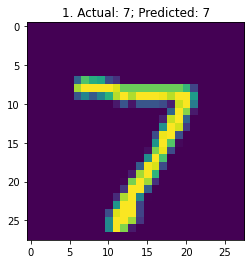

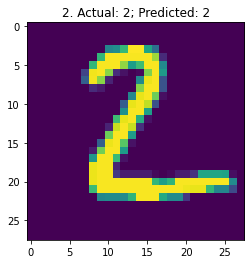

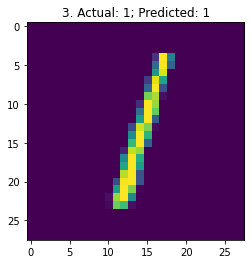

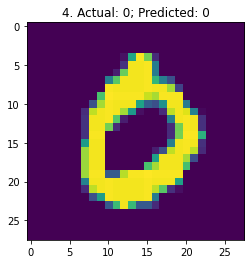

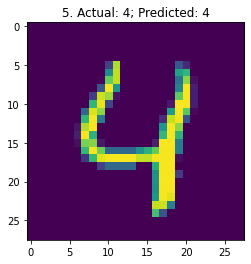

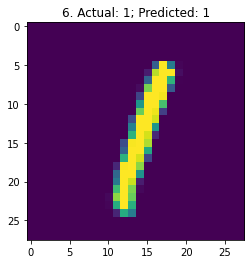

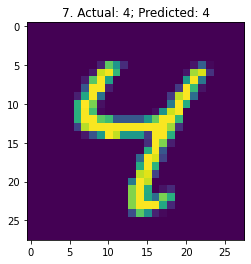

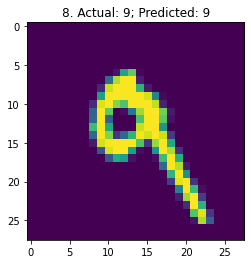

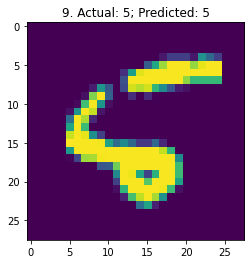

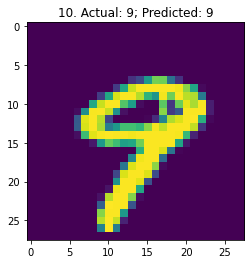

In [14]:
total, correct = test(net, mnist_testset, visualize=True)

In [15]:
print(f"Accuracy: {(correct/total)*100}% ({correct}/{total})")

Accuracy: 98.54999542236328% (9855/10000)


The model predicted 98.55% (9855/10000) of the test set correctly. 